In [14]:
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
from IPython.display import HTML

In [15]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)
session = tf.InteractiveSession()

In [16]:
class DataDistribution(object):
    def __init__(self):
        self.mu = 0
        self.sigma = 1

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples      


In [17]:
from abc import ABCMeta, abstractmethod

class GeneratorDistribution:
    __metaclass__ = ABCMeta

    @abstractmethod
    def __init__(self): pass
    
    @abstractmethod
    def sample(self, N): pass

class Uniform(GeneratorDistribution):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + \
            np.random.random(N) * 0.01

class Gauss(GeneratorDistribution):
    def __init__(self, mean_, std_):
        self.mean = mean_
        self.std = std_

    def sample(self, N):
        return np.random.normal(self.mean, self.std, N)

In [18]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + \
            np.random.random(N) * 0.01

class GeneratorDistributionGauss(object):
    def __init__(self, mean_, std_):
        self.mean = mean_
        self.std = std_

    def sample(self, N):
        return np.random.normal(self.mean, self.std, N)


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


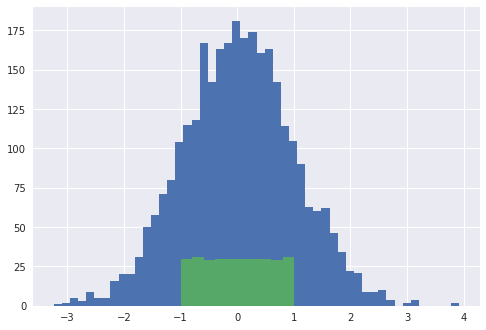

In [19]:
a = Gauss(mean_ = 0.0, std_ = 1.0)
sampl = a.sample(3000)
b = Uniform(1)
sampl_b = b.sample(300)
plt.hist(sampl, bins = 50)
plt.hist(sampl_b)
plt.show()

In [20]:
tf.reset_default_graph()


def generator(input, h_dim, act = 0):
    #transform, params = mlp(input, h_dim)
    if (act == 0):
        nn = tf.layers.dense(input, 4, activation=tf.nn.softplus)
    elif (act == 1):
        nn = tf.layers.dense(input, 4, activation=tf.nn.sigmoid)
    elif (act == 2):
        nn = tf.layers.dense(input, 4, activation=None)
    init_const = tf.constant_initializer(0.0)
    init_norm = tf.random_normal_initializer()
    w = tf.get_variable('g_w', [h_dim, 1], initializer=init_norm)
    b = tf.get_variable('g_b', [1], initializer=init_const)
    h = tf.matmul(nn, w) + b
    return h, [w, b]


def discriminator(input, h_dim):
    #transform, params = mlp(input, h_dim)
    with tf.variable_scope(tf.get_variable_scope(), reuse=False):
        nn = tf.layers.dense(input, 4, activation=tf.nn.sigmoid)
        transform = tf.layers.dense(nn, 4, activation=tf.nn.sigmoid)
        init_const = tf.constant_initializer(0.0)
        init_norm = tf.random_normal_initializer()
        w = tf.get_variable('d_w', [h_dim, 1], initializer=init_norm)
        b = tf.get_variable('d_b', [1], initializer=init_const)
        h = tf.sigmoid(tf.matmul(transform, w) + b)
    return h, [w, b]



In [21]:
def optimizer(loss, var_list, num_decay_steps=400, initial_learning_rate=0.03):
    decay = 0.95
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer


In [22]:
def plot_distributions(GAN, session, loss_d, loss_g, generator_z):
    num_points = 100000
    num_bins = 100

    xs =np.random.normal(GAN.data.mu, GAN.data.sigma, num_points)
    bins = np.linspace(-8, 8, num_bins)

    # p(data)
    d_sample = GAN.data.sample(num_points)

    # decision boundary
    ds = np.zeros((num_points, 1))  # decision surface
    for i in range(num_points // GAN.batch_size):
        ds[GAN.batch_size * i:GAN.batch_size * (i + 1)] = session.run(GAN.D1, {
            GAN.x: np.reshape(xs[GAN.batch_size * i:GAN.batch_size * (i + 1)], (GAN.batch_size, 1))
        })

    # p(generator)
    zs = generator_z.sample(num_points)
    gs = np.zeros((num_points, 1))  # generator function
    for i in range(num_points // GAN.batch_size):
        gs[GAN.batch_size * i:GAN.batch_size * (i + 1)] = session.run(GAN.G, {
            GAN.z: np.reshape(
                zs[GAN.batch_size * i:GAN.batch_size * (i + 1)],
                (GAN.batch_size, 1)
            )
        })
           
    anim_frames.append((d_sample, ds, gs, loss_d, loss_g))

## Build GAN ##

In [23]:

class GAN(object):
    def __init__(self, data, gen, num_epochs, act=0):
        self.d_act = act
        self.data = data
        self.gen = gen
        self.num_epochs = num_epochs
        self.log_every = 100
        self.anim_frame_every = 5
        self.batch_size = 128
        self.mlp_hidden_size = 4
        self._create_model()
        print ('Data len:', len(self.data.sample(self.batch_size)))
        print ('Data distribution')
        plt.hist(self.data.sample(self.batch_size), alpha = 0.5, bins = 50)

        print ('Gen data len:', len(self.data.sample(self.batch_size)))
        print ('Gen data distribution')
        plt.hist(self.gen.sample(self.batch_size),  alpha = 0.5, bins = 50)
        plt.show()

    def _create_model(self):
        # In order to make sure that the discriminator is providing useful gradient
        # information to the generator from the start, we're going to pretrain the
        # discriminator using a maximum likelihood objective. We define the network
        # for this pretraining step scoped as D_pre.
        with tf.variable_scope('D_pre'):
            self.pre_input = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.pre_labels = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            D, self.pre_theta = discriminator(self.pre_input, self.mlp_hidden_size)
            self.pre_loss = tf.reduce_mean(tf.square(D - self.pre_labels))
            self.pre_opt = optimizer(self.pre_loss, None, self.num_epochs)
        
        # This defines the generator network - it takes samples from a noise
        # distribution as input, and passes them through an MLP.
        with tf.variable_scope('G'):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G, theta_g = generator(self.z, self.mlp_hidden_size)

        # The discriminator tries to tell the difference between samples from the
        # true data distribution (self.x) and the generated samples (self.z).
        #
        # Here we create two copies of the discriminator network (that share parameters),
        # as you cannot use the same network with different inputs in TensorFlow.
        with tf.variable_scope('D') as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.D1, self.theta_d1 = discriminator(self.x, self.mlp_hidden_size) # discriminator return output, parameters w
            scope.reuse_variables()
            self.D2, self.theta_d2 = discriminator(self.G, self.mlp_hidden_size)

        # Define the loss for discriminator and generator networks (see the original
        # paper for details), and create optimizers for both
        self.loss_d = tf.reduce_mean(-tf.log(self.D1) - tf.log(1 - self.D2))
        self.loss_g = tf.reduce_mean(-tf.log(self.D2))

        self.opt_d = optimizer(self.loss_d, self.theta_d2, self.num_epochs)
        self.opt_g = optimizer(self.loss_g, theta_g, self.num_epochs)
    
    def train(self):
        with tf.Session() as sess:
            tf.initialize_all_variables().run()

            # discriminator pretraining
            num_pretrain_steps = 1000
            for step in range(num_pretrain_steps):
                d = (np.random.random(self.batch_size) - 0.5) * 10.0
                labels = norm.pdf(d, loc=self.data.mu, scale=self.data.sigma)
                pretrain_loss, _ = sess.run([self.pre_loss, self.pre_opt], {
                    self.pre_input: np.reshape(d, (self.batch_size, 1)),
                    self.pre_labels: np.reshape(labels, (self.batch_size, 1))
                })
            self.weightsD = sess.run(self.pre_theta)

            # copy weights from pre-training over to new D network
            for i, v in enumerate(self.theta_d2):
                sess.run(v.assign(self.weightsD[i]))

            for step in range(self.num_epochs):
                # update discriminator
                x = self.data.sample(self.batch_size)
                z = self.gen.sample(self.batch_size)

                loss_d, _ = sess.run([self.loss_d, self.opt_d], {
                    self.x: np.reshape(x, (self.batch_size, 1)),
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                # update generator
                z = self.gen.sample(self.batch_size)
                loss_g, _ = sess.run([self.loss_g, self.opt_g], {
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                if step % self.log_every == 0:
                    print('{}: {}\t{}'.format(step, loss_d, loss_g))

                if step % self.anim_frame_every == 0:
                    plot_distributions(self, sess, loss_d, loss_g, self.gen)



## Train it ##

In [11]:
## z = gauss, act = t

In [24]:
def simple_print(number):
    bins = np.linspace(-5, 5, 50)

    f, ax = plt.subplots(figsize=(6,4))
    f.suptitle('1D Generative Adversarial Network', fontsize=15)
    plt.ylabel('Probability')
    ax.set_xlim(-6, 6)
    ax.set_ylim(0, 2.5)
    line_d, = ax.plot([], [], label='p_d')
    line_ds, = ax.plot([], [], label='decision boundary')
    line_g, = ax.plot([], [], label='p_g')

    histd, _ = np.histogram(anim_frames[number][0], bins=bins, normed=True)
    line_d.set_data(bins[1:], histd)


    histg, _ = np.histogram(anim_frames[number][2], bins=bins, normed=True)
    line_g.set_data(bins[1:], histg)

    frame_text = ax.text(0.02, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
    ax.legend()
    plt.show()

Data len: 128
Data distribution
Gen data len: 128
Gen data distribution


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


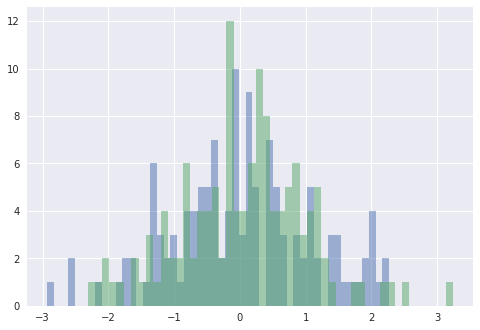

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0: 2.5135538578033447	2.334949493408203
100: 1.3959290981292725	0.7294681072235107
200: 1.3937405347824097	0.6857129335403442
300: 1.392755389213562	0.6830863952636719
400: 1.3920104503631592	0.6835999488830566
500: 1.3929091691970825	0.6833274364471436
600: 1.3906724452972412	0.6831636428833008
700: 1.3931077718734741	0.682691752910614
800: 1.3926689624786377	0.6830636262893677
900: 1.392630696296692	0.6818464398384094
1000: 1.3915101289749146	0.6826315522193909
1100: 1.391244649887085	0.6815993785858154
1200: 1.391693353652954	0.6827282309532166
1300: 1.391007900238037	0.682062029838562
1400: 1.3907980918884277	0.6822515726089478


In [40]:
anim_frames = []
num_epochs = 1500
model = GAN(DataDistribution(), Gauss(mean_ = 0.0, std_ = 1.0), num_epochs)
model.train()

300


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


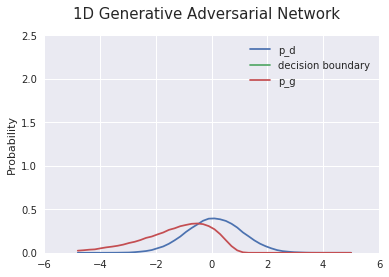

HALF


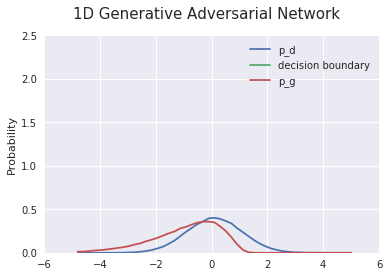

In [41]:
a = len(anim_frames)
print(a)
simple_print(int(a-2))
print ('HALF')
simple_print(int(100))

Data len: 128
Data distribution
Gen data len: 128
Gen data distribution


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


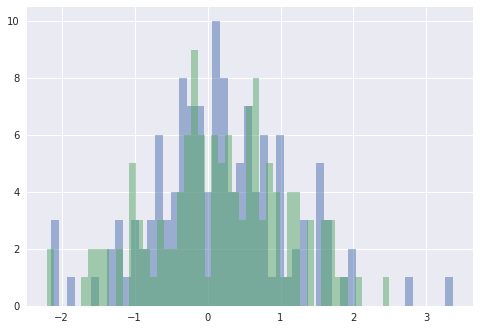

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0: 2.3696892261505127	2.2170939445495605
100: 1.3932844400405884	0.7664942741394043
200: 1.3871010541915894	0.6965019702911377
300: 1.3874026536941528	0.6925575733184814
400: 1.3874605894088745	0.6923044323921204
500: 1.3875867128372192	0.6921926736831665
600: 1.3875536918640137	0.6923278570175171
700: 1.3877253532409668	0.6923006772994995
800: 1.3874253034591675	0.6921217441558838
900: 1.3875291347503662	0.6921374797821045
1000: 1.387203335762024	0.6921442747116089
1100: 1.3876028060913086	0.6920075416564941
1200: 1.387140154838562	0.6921297907829285
1300: 1.387379765510559	0.6921418905258179
1400: 1.3876395225524902	0.6920570135116577


In [49]:
anim_frames = []
num_epochs = 1500
model = GAN(DataDistribution(), Gauss(mean_ = 0.0, std_ = 1.0), num_epochs, act = 1)
model.train()

300


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


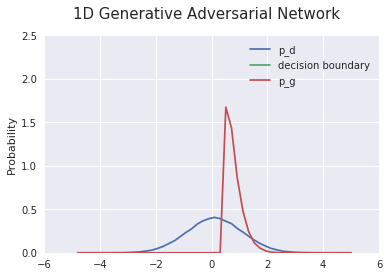

HALF


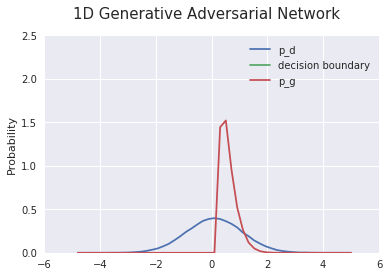

In [53]:
a = len(anim_frames)
print(a)
simple_print(int(a-2))
print ('HALF')
simple_print(int(100))

Data len: 128
Data distribution
Gen data len: 128
Gen data distribution


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


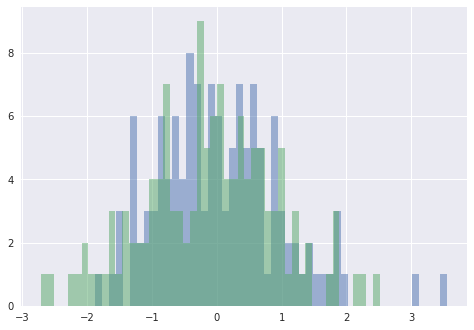

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0: 2.024904251098633	1.850928783416748
100: 1.3780734539031982	0.7544193267822266
200: 1.3730658292770386	0.7028896808624268
300: 1.374678373336792	0.7002781629562378
400: 1.3733110427856445	0.699928879737854
500: 1.3733854293823242	0.6996525526046753
600: 1.3756898641586304	0.6993736028671265
700: 1.3736798763275146	0.6991218328475952
800: 1.3735802173614502	0.6986680030822754
900: 1.3738566637039185	0.6983073949813843
1000: 1.3759129047393799	0.6978132128715515
1100: 1.378415584564209	0.6971702575683594
1200: 1.378274917602539	0.696457028388977
1300: 1.3780608177185059	0.6960225701332092
1400: 1.3802402019500732	0.695623517036438


In [20]:
anim_frames = []
num_epochs = 1500
model = GAN(DataDistribution(), Gauss(mean_ = 0.0, std_ = 1.0), num_epochs, act = 2)
model.train()

300


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


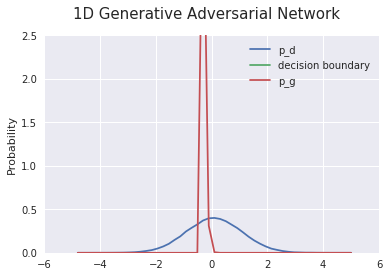

HALF


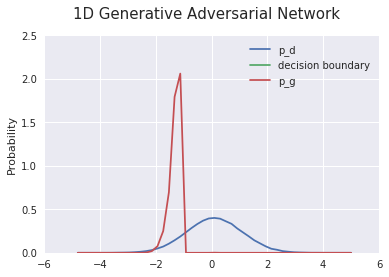

In [22]:
a = len(anim_frames)
print(a)
simple_print(int(a-2))
print ('HALF')
simple_print(int(100))

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed', 'rc', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Data len: 128
Data distribution
Gen data len: 128
Gen data distribution


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


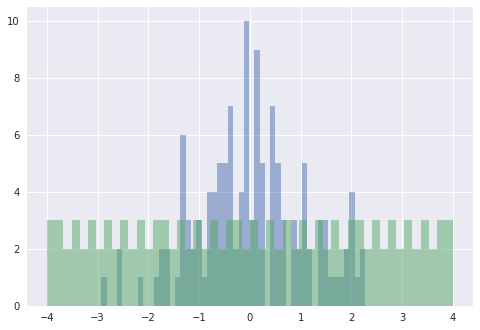

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0: 1.9096434116363525	1.5894813537597656
100: 1.448076844215393	0.6955727338790894
200: 1.438067078590393	0.6712833642959595
300: 1.4279502630233765	0.6757652163505554
400: 1.4143729209899902	0.6826471090316772
500: 1.4005169868469238	0.6896153688430786
600: 1.3869465589523315	0.6964021921157837
700: 1.3739948272705078	0.7024129629135132
800: 1.3660763502120972	0.7074564695358276
900: 1.3517558574676514	0.7108683586120605
1000: 1.3531219959259033	0.7111859321594238
1100: 1.3593471050262451	0.7084290981292725
1200: 1.3748602867126465	0.7010261416435242
1300: 1.3774855136871338	0.6925977468490601
1400: 1.4025280475616455	0.6829788684844971
1500: 1.4187583923339844	0.6773054599761963


In [12]:
anim_frames = []
num_epochs = 1600
model = GAN(DataDistribution(), Uniform(4), num_epochs, act = 2)
model.train()

320


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


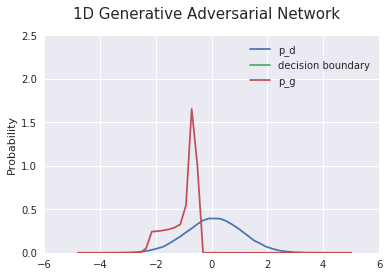

HALF


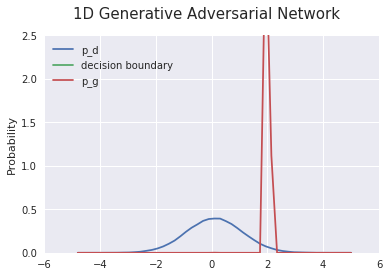

In [13]:
a = len(anim_frames)
print(a)
simple_print(int(a-2))
print ('HALF')
simple_print(int(100))

Data len: 128
Data distribution
Gen data len: 128
Gen data distribution


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


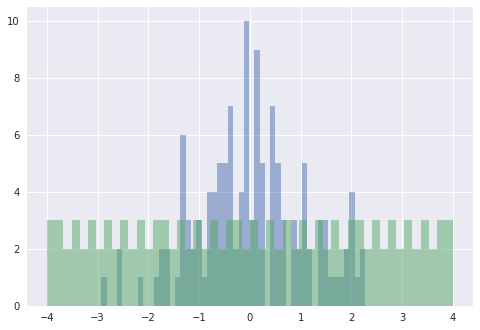

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0: 1.8057993650436401	1.5530879497528076
100: 1.394078016281128	0.7608940601348877
200: 1.3893696069717407	0.6957290172576904
300: 1.3905181884765625	0.6881791353225708
400: 1.3913147449493408	0.686548113822937
500: 1.3919516801834106	0.685576319694519
600: 1.3931878805160522	0.6844028830528259
700: 1.3935027122497559	0.6838606595993042
800: 1.392082691192627	0.6830847263336182
900: 1.3947858810424805	0.6824886798858643
1000: 1.393306016921997	0.6823074221611023
1100: 1.3924884796142578	0.6819934844970703
1200: 1.3914748430252075	0.6820601224899292
1300: 1.3928272724151611	0.6816197633743286
1400: 1.3912928104400635	0.6818950176239014
1500: 1.390250563621521	0.6820245981216431


In [25]:
anim_frames = []
num_epochs = 1600
model = GAN(DataDistribution(), Uniform(4), num_epochs)
model.train()

320


/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


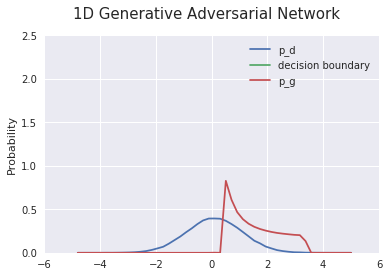

HALF


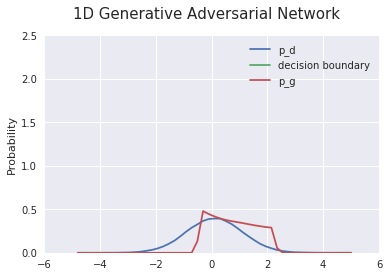

In [26]:
a = len(anim_frames)
print(a)
simple_print(int(a-2))
print ('HALF')
simple_print(int(100))

## отладка##

In [ ]:
tf.reset_default_graph()
_input = tf.placeholder(tf.float32, shape=(128, 1))
nn = tf.layers.dense(_input, 4, activation=tf.nn.sigmoid)
transform = tf.layers.dense(nn, 4, activation=tf.nn.sigmoid)
transform_1, params = mlp(_input, 4)
init_const = tf.constant_initializer(0.0)
init_norm = tf.random_normal_initializer()
w = tf.get_variable('d_w', [4, 1], initializer=init_norm)
b = tf.get_variable('d_b', [1], initializer=init_const)
print ('transform.shape', transform.get_shape)
print ('w.shape', w.get_shape)
print ('b.shape', b.get_shape)
res = tf.matmul(transform, w) + b
print ('res.shape', res.get_shape)